# Establishing a Good Distance Between Flu Sequences

First we need to establish the meaning of a distance between Influenza sequences. We will look at a special subset of the data where we know roughly what the similarity/distance is bewtween a pair. 

## Jaccard with k-grams

We will run k-grams and Jaccard similarity on the sequences and cross validate and see if the ones who are similar match our domain knowledge.

In [1]:
import pickle
import gzip
import numpy as np
import pandas as pd
import numba
from collections import Counter
from itertools import product
from FASTA_parse import sequence

In [2]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (6,4)
#plt.style.use('seaborn')

In [3]:
# read in the sequences
with gzip.open('influenza.fna.pklz', 'rb') as fin:
    fna = pickle.load(fin)

In [4]:
fna_meta, fna_seq = fna.get_dataframe()

In [5]:
fna_seq.drop_duplicates(subset='Sequence', inplace=True)

In [6]:
def tokenize(seq, grams=5):
    split = [seq[i:i+grams] for i in range(len(seq)-grams+1)]
    return split

def generate_vocab(grams=2):
     # generate general "vocab" list
    vocab = Counter()
    for t in product('ACTG', 'ACTG', repeat=grams):
        s = []
        for i in range(grams):
            s.append(t[i])
        vocab[''.join(s)] = 0
        
    return vocab

def generate_vec(seq_list, vocab, grams, r):
    new_vec_col = []
    for seq in seq_list:
        vec = vocab.copy()
        tokens = tokenize(seq, grams=grams)
        for j, gram in enumerate(tokens):
            vec[gram] += 1
            
        new_vec_col.append(np.array(vec.values(), dtype=np.int8))
        
    return new_vec_col
    
def generate_bag(seq_df, grams=2, r=0):
    # generate general "vocab" list
    vocab = generate_vocab(grams)
    
    new_vec = np.zeros(shape=(seq_df.shape[0], 4**grams))
    
    for i, seq in enumerate(seq_df.Sequence):
        vec = vocab.copy()
        for j, gram in enumerate(tokenize(seq, grams=grams)):
            if gram in vec:
                vec[gram] += 1
        
        new_vec[i] = np.array(list(vec.values()), dtype=np.int8)
    
    return new_vec
                    

In [98]:
BOW_5 = generate_bag(fna_seq.sample(1000), grams=4)

In [6]:
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import CountVectorizer

In [15]:
k=6

sample = fna_seq.sample(10000)
vectorizer = CountVectorizer(analyzer='char', ngram_range=(k,k))
X = vectorizer.fit_transform(sample.Sequence.tolist())

In [16]:
import re
idxs = []
for i,token in enumerate(vectorizer.get_feature_names()):
    if re.match('^[actg]+$', token):
        idxs.append(i)
        
features = np.array(vectorizer.get_feature_names())[idxs]
X = X.toarray()[:,idxs]

In [17]:
inert = np.zeros(shape=(20-2))

for k in range(2,20):
    km = KMeans(k)
    km.fit_predict(X)
    inert[k-5] = km.inertia_
    
inert

array([13198642.54600296, 12553007.75228862, 12209930.99407126,
       11644245.6277294 , 11127672.52914314, 10879087.41325957,
       10395729.41713197,  9993874.59010872,  9733377.67287788,
        9596736.36094635,  9248152.92586149,  9108695.62240529,
        8862642.01905169,  8606247.50879966,  8458268.61926747,
       15491308.44944889, 14724694.95562062, 13797191.42997746])

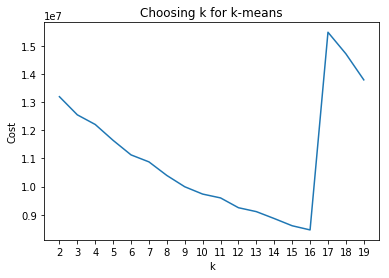

In [18]:
plt.plot(np.arange(2,20,1), inert)
plt.xticks(np.arange(2,20,1))
plt.title('Choosing k for k-means')
plt.xlabel('k')
plt.ylabel('Cost')
plt.savefig('choosing_k.jpg', dpi=300, pad_inches=.01)

[0.11570362 0.05837209]


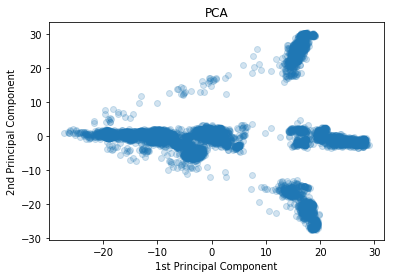

In [20]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
new_X = pca.fit_transform(X)
print(pca.explained_variance_ratio_)

plt.scatter(new_X[:,0], new_X[:,1], alpha=.2)
plt.xlabel('1st Principal Component')
plt.ylabel('2nd Principal Component')
plt.title('PCA')
plt.show()